In [1]:
warnings="""
Warning 6: Normalized/laundered field name: 'SAFStreetName' to 'SAFStreetN'
Warning 6: Normalized/laundered field name: 'SAFStreetCode' to 'SAFStreetC'
Warning 6: Normalized/laundered field name: 'LATOMICPOLYGON' to 'LATOMICPOL'
Warning 6: Normalized/laundered field name: 'RATOMICPOLYGON' to 'RATOMICPOL'
Warning 6: Normalized/laundered field name: 'LBlockFaceID' to 'LBlockFace'
Warning 6: Normalized/laundered field name: 'RBlockFaceID' to 'RBlockFace'
Warning 6: Normalized/laundered field name: 'StreetWidth_Min' to 'StreetWidt'
Warning 6: Normalized/laundered field name: 'StreetWidth_Max' to 'StreetWi_1'
Warning 6: Normalized/laundered field name: 'StreetWidth_Irr' to 'StreetWi_2'
Warning 6: Normalized/laundered field name: 'BIKE_TRAFDIR' to 'BIKE_TRAFD'
Warning 6: Normalized/laundered field name: 'ACTIVE_FLAG' to 'ACTIVE_FLA'
Warning 6: Normalized/laundered field name: 'POSTED_SPEED' to 'POSTED_SPE'
Warning 6: Normalized/laundered field name: 'Snow_Priority' to 'Snow_Prior'
Warning 6: Normalized/laundered field name: 'Number_Travel_Lanes' to 'Number_Tra'
Warning 6: Normalized/laundered field name: 'Number_Park_Lanes' to 'Number_Par'
Warning 6: Normalized/laundered field name: 'Number_Total_Lanes' to 'Number_Tot'
Warning 6: Normalized/laundered field name: 'Carto_Display_Level' to 'Carto_Disp'
Warning 6: Normalized/laundered field name: 'SHAPE_Length' to 'SHAPE_Leng'
""".split("\n")
import re
froms_tos = [tuple(re.findall('\w+', w.strip().split(":")[-1])[::2]) for w in warnings if w]

In [2]:
import geopandas as gpd
import geopy
import geopy.distance
import pandas as pd
import matplotlib 
import networkx as nx
import numpy as np
%matplotlib inline
pd.options.display.max_columns = None

def uniform_str(x):
    strd = str(x)
    while len(strd) < 7:
        strd = '0' + strd
    return strd


In [ ]:
manhattan_lines = gpd.read_file("data/mn_lines.shp")
manhattan_nodes = gpd.read_file("data/mn_nodes.shp")

In [ ]:
manhattan_nodes["ID_STR"] = manhattan_nodes["NODEID"].apply(uniform_str)

In [3]:
all_nodes = gpd.read_file("data/lion/lion.shp/node.shp")
all_nodes["ID_STR"] = all_nodes["NODEID"].apply(uniform_str)
all_nodes[all_nodes["ID_STR"] == "0048606"]

,NODEID,VIntersect,geometry,ID_STR
46072,48606,,POINT (1010053.05149962 257493.4766098112),0048606


In [4]:
nodes_by_id = all_nodes.set_index("ID_STR")

In [ ]:
# manhattan_lines["BikeLane"].unique()

# pd.DataFrame(line).swapaxes(1, 0)

In [ ]:
g = nx.DiGraph()
errors = []

def dist_func(u, v):
    u_n = nodes_by_id.loc[u]
    u_coord = (u_n.geometry.x, u_n.geometry.y)
    v_n = nodes_by_id.loc[v]
    v_coord = (v_n.geometry.x, v_n.geometry.y)
    dist = geopy.distance.vincenty(u_coord, v_coord).miles
    return dist

def handle_line(ix, line, graph):
    code = line["TrafDir"]
    if code not in {"W", "A", "T"}:
        return
    
    u = line["NodeIDFrom"]
    v = line["NodeIDTo"]
    dist = line["SHAPE_Leng"] / 5280.
    try:
        speed = float(line["POSTED_SPE"])
    except:
        errors.append(line["Street"])
        speed = 25.
    attrs = {"dist": dist, "speed": speed, "weight": 60. * dist / speed, "ix": ix}
    if code == "W":
        # from -> to
        g.add_edge(u, v, attrs)
    elif code == "A":
        # to -> from
        g.add_edge(v, u, attrs)
    elif code == "T":
        # to <-> from
        g.add_edge(u, v, attrs)
        g.add_edge(v, u, attrs)

        
for ix, line in manhattan_lines.iterrows():
    handle_line(ix, line, g)

In [ ]:
f1 = manhattan_lines.iloc[0].NodeIDFrom
f2 = manhattan_lines[manhattan_lines["Street"].str.contains("FDR")].iloc[0].NodeIDFrom
path = nx.algorithms.shortest_path(g, f1, f2)
path[0]
f1 == path[0]

In [ ]:
ax = nodes_by_id.loc[[f1, f2]].plot(figsize=(16, 9))
for thing in path:
    nodes_by_id.loc[[thing]].plot(ax=ax)

In [ ]:
nx.write_gpickle(g, "data/init_graph.pkl")

In [5]:
import networkx as nx
g = nx.read_gpickle("data/init_graph.pkl")

In [38]:
things = nx.algorithms.strongly_connected_components(g)

In [39]:
pd.Series([len(t) for t in things]).unique()

array([    1, 12263,   126,   113,    45,     3,     2])

In [12]:
singletons = [t for t in things if len(t) == 1]

In [17]:
len(singletons)

115

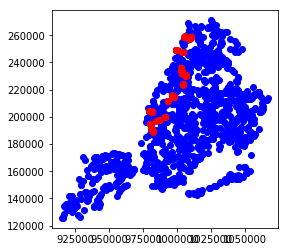

In [16]:
ax = nodes_by_id.sample(1000).plot(color='blue')
[nodes_by_id.loc[l].plot(color='red', ax=ax) for l in singletons]

In [31]:
e0, e1 = g.edges()[0]
g.edge[e0][e1]

{'dist': 0.11436198655596957,
 'ix': 9285,
 'speed': 25.0,
 'weight': 0.274468767734327}

## Early loading code